# Assignment 2.2 Convolutional network

In [7]:
import os
import numpy as np
import skimage
from skimage import io, transform, color, filters, data, morphology, measure
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    images_name = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            images_name.append(filename[0:4])
    
    images_df = pd.DataFrame({"name": images_name,
                             "image": images})
    return images_df

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    
    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

De hierboven gedefineerde functies zijn geleverd door Saxion zelf. Die zullen gebruikt worden voor het inladen van de data en het tonen van de afbeeldingen.

Hieronden wordt de data ingeladen. Voor de zekerheid zullen we de data ook printen.

In [8]:
all_images_df = load_images_from_folder('./dataset-images')
all_images_df

,name,image
0,1000,"[[[241, 241, 241], [242, 242, 242], [244, 244,..."
1,1027,"[[[206, 206, 206], [211, 211, 211], [218, 218,..."
2,1029,"[[[82, 82, 82], [83, 83, 83], [84, 84, 84], [8..."
3,1036,"[[[241, 241, 241], [246, 246, 246], [243, 243,..."
4,1053,"[[[241, 241, 241], [243, 243, 243], [243, 243,..."
...,...,...
475,9867,"[[[231, 231, 231], [227, 227, 227], [225, 225,..."
476,9909,"[[[77, 77, 77], [74, 74, 74], [78, 78, 78], [7..."
477,9923,"[[[116, 116, 116], [114, 114, 114], [113, 113,..."
478,9954,"[[[105, 105, 105], [102, 102, 102], [110, 110,..."


Zoals hierboven is te zien is de data succesvol geladen. Laten we voor de zekerheid kijken of er toch geen gebreken zijn. Hiervoor zullen we de "describe()" functie gebruiken.

In [9]:
all_images_df.describe()

,name,image
count,480,480
unique,480,480
top,7047,"[[[148, 148, 148], [158, 158, 158], [148, 148,..."
freq,1,1


Voor nu lijkt de data in orde dus kunnen we verder gaan.

De data is nu verzameld.

Om de data te kunnen gebruiken voor het neurale netwerk zullen we het eerst moeten preprocessen en de features eruit halen.

Hieronder zullen we een begin maken met het schrijven van de eerste versie van de preproces pipeline. Hiervoor zullen we de volgende stappen uitvoeren:

1. De kleuren van de afbeelding omdraaien, zodat de cijfers wit zijn en de achtergrond zwart.
2. De afbeelding omzetten naar een binair formaat (zwart/wit).
3. Afbeelding knippen naar 1 cijfer per afbeelding.
4. Dataset opzetten zodat we het neurale netwerk trainen per cijfer in plaats van op een hele reeks

## De kleuren van de afbeelding omdraaien, zodat de cijfers wit zijn en de achtergrond zwart.

In [10]:
image = all_images_df.iloc[0,1]
image_name = all_images_df.iloc[0,0]

image = image*-1

## De afbeelding omzetten naar een binair formaat (zwart/wit).

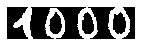

In [11]:
gray = color.rgb2gray(image)
thresh = filters.threshold_otsu(gray)
binary = gray > thresh
display(binary)

In [12]:
def initialize_image(image, image_name):
    zipcode = image
    zipcode = zipcode *-1
    gray = color.rgb2gray(zipcode)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    binary_splitted = [binary[:, :32], binary[:, 32:64], binary[:, 64:96], binary[:, 96:128]]
    
    df = pd.DataFrame(columns=['feature', 'number'])
    
    for x in range(0, 4):
        df.loc[x, 'number'] = image_name[x]
        df.loc[x, 'feature'] = binary_splitted[x]
    
    return df
    
result = pd.DataFrame()

for i in range(0, len(all_images_df.index)):
    image_name = all_images_df.iloc[i,0]
    image = all_images_df.iloc[i,1]
    tmp_result = initialize_image(image, image_name)
    result = pd.concat([result, tmp_result])
    
result.reset_index(inplace=True)
result.drop(columns=['index'], inplace=True)
result

,feature,number
0,"[[False, False, False, False, False, False, Fa...",1
1,"[[False, False, False, False, False, False, Fa...",0
2,"[[False, False, False, False, False, False, Fa...",0
3,"[[False, False, False, False, False, False, Fa...",0
4,"[[False, False, False, False, False, False, Fa...",1
...,...,...
1915,"[[False, False, False, False, False, False, Fa...",4
1916,"[[False, True, False, False, False, True, Fals...",9
1917,"[[False, False, False, False, False, False, Fa...",9
1918,"[[False, False, False, False, True, False, Fal...",9


Nu we de afbeeldingen hebben omgezet, kunnen we de dataset splitsen in train en test data. De test data willen we vederop gebruiken om het netwerk te testen.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        result['feature'], result['number'], test_size=0.1, random_state=28)


In [14]:
len(X_train)

1728

In [15]:
len(X_test)

192

De targets zullen we categoriseren naar numerieke waardes die gebruikt kunnen worden voor het netwerk. Dit doen we door middel van OneHOtEncoding. 

In [16]:
from keras.utils import to_categorical
#one-hot encode target column
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_train_encoded[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [17]:
#This is needed to avoid an array in array situation.
tt = np.vstack(X_train)
X_train = tt.reshape(len(X_train),32,32)
rr = np.vstack(X_test)
X_test = rr.reshape(len(X_test),32,32)

De data is nu klaar. we moeten we alleen de structuur van de data veranderen zodat het voldoet aan de verwachte input van het neurale netwerk.

In [18]:
#reshape data to fit model
X_train = X_train.reshape(len(X_train),32,32,1)
X_test = X_test.reshape(len(X_test),32,32,1)
X_train.shape

(1728, 32, 32, 1)

In [19]:
X_test.shape

(192, 32, 32, 1)

In [20]:
y_train_encoded[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [21]:
y_train.shape

(1728,)

Nu kunnen we het neurale netwerk bouwen. Daarin geven we de structuur van de input aan, wat in ons geval (32,32,1) is. Daarnaast zal de output layer bestaan uit 10 nodes, omdat het getal tussen de reeks van [0-9] zit.

Voor de output layer zal er gebruik gemaakt worden van Softmax. Softmax wordt namelijk gebruikt voor classificatie problemen

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = None
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [23]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Nu het neurale netwerk is opgezet kunnen we beginnen met de eerste training

In [24]:
#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 3s 60ms/step - loss: 1.0692 - accuracy: 0.6382 - val_loss: 0.2950 - val_accuracy: 0.9249
Epoch 2/3
49/49 [==============================] - 3s 55ms/step - loss: 0.1152 - accuracy: 0.9650 - val_loss: 0.2669 - val_accuracy: 0.9364
Epoch 3/3
49/49 [==============================] - 3s 53ms/step - loss: 0.0444 - accuracy: 0.9850 - val_loss: 0.2892 - val_accuracy: 0.9480


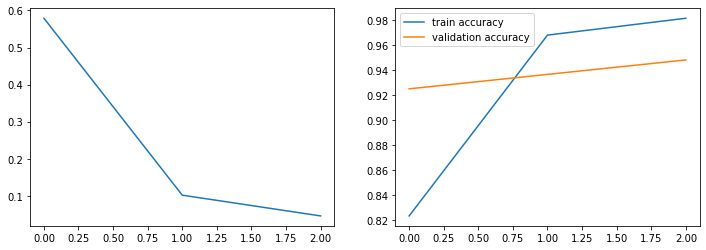

In [25]:
from matplotlib import pyplot
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

Kijkend naar de eerste resultaten lijkt het neurale netwerk aardig goed te presteren. De loss zit ook zeer laag. Met een kleine aantal epochs zit de accuraatheid hoog. De validatie accuraatheid zit ook in de buurt van de train accuraatheid. Dus het lijkt niet veel last te hebben van overfitting.

Het idee is om nu 5 andere neurale netwerken te creeeren om te experimenteren hoe de overige modellen presteren.

## Netwerk 2

In [26]:
#create model
model = None
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 3s 58ms/step - loss: 1.3838 - accuracy: 0.5953 - val_loss: 0.3489 - val_accuracy: 0.9133
Epoch 2/3
49/49 [==============================] - 3s 54ms/step - loss: 0.1290 - accuracy: 0.9702 - val_loss: 0.2930 - val_accuracy: 0.9364
Epoch 3/3
49/49 [==============================] - 3s 54ms/step - loss: 0.0756 - accuracy: 0.9736 - val_loss: 0.2508 - val_accuracy: 0.9422


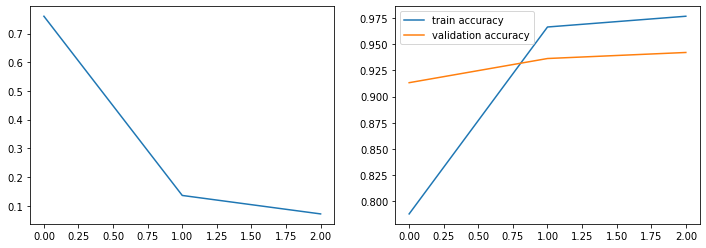

In [27]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

de resultaten van netwerk 2 is eigenlijk vergelijkbaar met netwerk 1. De validatie accuraatheid heeft alleen geen dalende lijn. Het toevoegen van een extra layer lijkt toch niet veel verschil te maken.

## Netwerk 3

In [28]:
#create model
model = None
model = Sequential()
#add model layers
model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(32,32,1)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 7s 138ms/step - loss: 1.0467 - accuracy: 0.6943 - val_loss: 0.3313 - val_accuracy: 0.9133
Epoch 2/3
49/49 [==============================] - 7s 134ms/step - loss: 0.1228 - accuracy: 0.9624 - val_loss: 0.2950 - val_accuracy: 0.9480
Epoch 3/3
49/49 [==============================] - 7s 134ms/step - loss: 0.0538 - accuracy: 0.9822 - val_loss: 0.4059 - val_accuracy: 0.9133


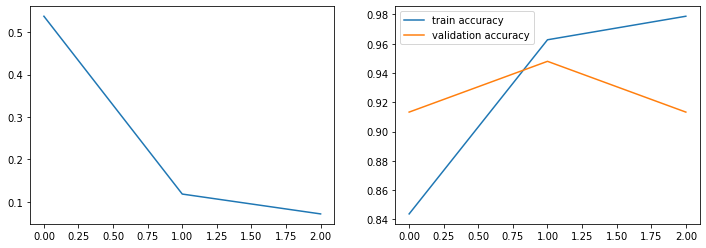

In [29]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

Ook het toevoegen van een extra convolutional layer lijkt geen drastische verschillen te maken in het trainen. Al merk ik wel op dat het trainen natuurlijk langer duurt. Dit is ook terug te zien in de step duratie die wordt aangegeven.

## Netwerk 4

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

inputs = keras.Input(shape=(32,32,1))

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

#add model layers
firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)
flattenLayer = Flatten()(secondLayer)
outputs = layers.Dense(10, activation="softmax")(flattenLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 3s 57ms/step - loss: 1.1593 - accuracy: 0.6324 - val_loss: 0.2916 - val_accuracy: 0.9306
Epoch 2/3
49/49 [==============================] - 3s 52ms/step - loss: 0.1328 - accuracy: 0.9542 - val_loss: 0.2384 - val_accuracy: 0.9249
Epoch 3/3
49/49 [==============================] - 3s 53ms/step - loss: 0.0582 - accuracy: 0.9823 - val_loss: 0.2965 - val_accuracy: 0.9306


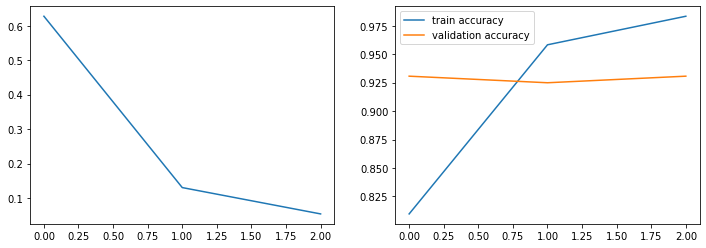

In [31]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

Het toevoegen van een preprocessor laag lijkt de accuraatheid verhoogd te hebben. Dit is ook nog gelukt zonder tijdverlies in training. 

## Netwerk 5

In [32]:
inputs = keras.Input(shape=(32,32,1))

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

#add model layers

firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)

poolLayer = layers.MaxPooling2D(pool_size=(3, 3), strides=None, padding="valid")(secondLayer)

flattenLayer = Flatten()(poolLayer)
outputs = layers.Dense(10, activation="softmax")(flattenLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)


Epoch 1/3
49/49 [==============================] - 3s 57ms/step - loss: 1.7576 - accuracy: 0.4577 - val_loss: 0.4905 - val_accuracy: 0.8844
Epoch 2/3
49/49 [==============================] - 3s 52ms/step - loss: 0.2683 - accuracy: 0.9168 - val_loss: 0.3691 - val_accuracy: 0.8786
Epoch 3/3
49/49 [==============================] - 3s 52ms/step - loss: 0.1143 - accuracy: 0.9660 - val_loss: 0.2639 - val_accuracy: 0.9249


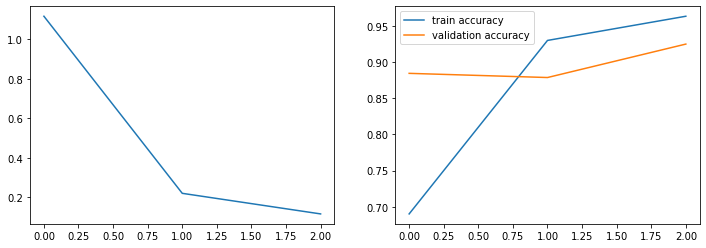

In [33]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

## Netwerk 6

In [34]:
inputs = keras.Input(shape=(32,32,1))

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

#add model layers

firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)

poolLayer = layers.AveragePooling2D(pool_size=(3, 3), strides=None, padding="valid")(secondLayer)

flattenLayer = Flatten()(poolLayer)
outputs = layers.Dense(10, activation="softmax")(flattenLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)


Epoch 1/3
49/49 [==============================] - 3s 57ms/step - loss: 1.6591 - accuracy: 0.4859 - val_loss: 0.4044 - val_accuracy: 0.9017
Epoch 2/3
49/49 [==============================] - 3s 53ms/step - loss: 0.1783 - accuracy: 0.9417 - val_loss: 0.2901 - val_accuracy: 0.9306
Epoch 3/3
49/49 [==============================] - 3s 54ms/step - loss: 0.1284 - accuracy: 0.9689 - val_loss: 0.2752 - val_accuracy: 0.9191


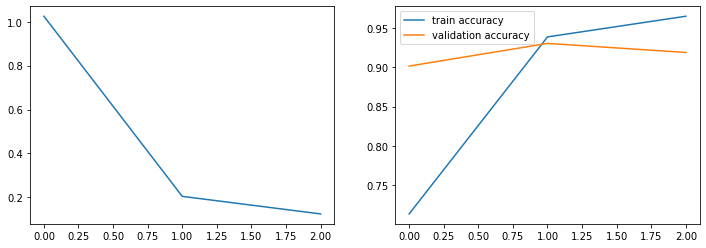

In [35]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

fhsdfsdiufhsdkjfhsdkfhdskfhskjdfkjsdfdsf

## Valideren neuraal netwerk

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

inputs = keras.Input(shape=(32,32,1))

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

#add model layers
firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)
flattenLayer = Flatten()(secondLayer)
outputs = layers.Dense(10, activation="softmax")(flattenLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 3s 60ms/step - loss: 1.1021 - accuracy: 0.6769 - val_loss: 0.4572 - val_accuracy: 0.8786
Epoch 2/3
49/49 [==============================] - 3s 56ms/step - loss: 0.1536 - accuracy: 0.9527 - val_loss: 0.2881 - val_accuracy: 0.9480
Epoch 3/3
49/49 [==============================] - 3s 56ms/step - loss: 0.0405 - accuracy: 0.9879 - val_loss: 0.2482 - val_accuracy: 0.9480


### Test dataset

Voor het valideren van het model gaan we eerst gebruik maken van de apart gehouden test dataset. Hiermee willen we controleren of het model last heeft van overfitting

In [37]:
prediction_result = model.evaluate(X_test, y_test_encoded, verbose=1)

6/6 [==============================] - 0s 12ms/step - loss: 0.1210 - accuracy: 0.9531


Volgens het model halen we met de test dataset een accuraatheid van 95.31%. Dit is een zeer hoge resultaat. Het lijkt erop dat het model niet veel last heeft van overfitting als we naar deze resultaten kijken. De loss zit ook zeer laag.

Dit zullen we nu verder valideren door cross validation te gebruiken

### Cross validation

In [38]:
from sklearn.model_selection import KFold

cross_validation_x = np.concatenate((X_train, X_test), axis=0)
cross_validation_y = np.concatenate((y_train_encoded, y_test_encoded), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

acc_per_fold = []
loss_per_fold = []

fold_no = 1

for train, test in kfold.split(cross_validation_x, cross_validation_y):
    Inputs = None
    inputs = keras.Input(shape=(32,32,1))

    #add preprocess layers
    preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

    #add model layers
    firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
    secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)
    flattenLayer = Flatten()(secondLayer)
    outputs = layers.Dense(10, activation="softmax")(flattenLayer)

    #create model
    model = None
    model = keras.Model(inputs, outputs)

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    #train the model
    history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3, verbose=0)
    
    # Generate generalization metrics
    scores = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.14223618805408478; accuracy of 93.75%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.10957453399896622; accuracy of 96.875%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.08818826824426651; accuracy of 95.83333134651184%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.10952356457710266; accuracy of 95.83333134651184%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.16118617355823517; accuracy of 94.27083134651184%


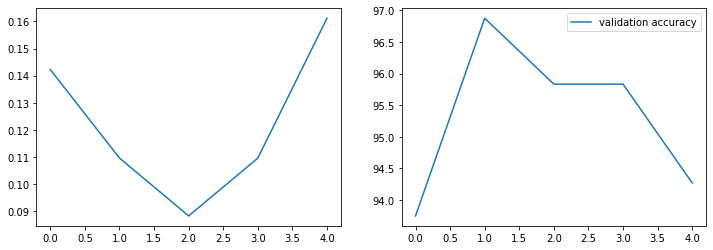

In [39]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(loss_per_fold, label='validation loss')
ax2.plot(acc_per_fold, label='validation accuracy')
pyplot.legend()
pyplot.show()

Als we naar de resultaten kijken, dan lijkt de accuraatheid en loss in de buurt van dezelfde waardes te blijven. Dit betekent iets positiefs. Hiermee kunnen we namelijk veronderstellen dat het model niet veel last heeft van overfitting.

### Dropout

Om verder te kijken naar overfitting zullen we dropout toepassen in het neuraal netwerk om de kans op overfitting te verlagen.

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

inputs = keras.Input(shape=(32,32,1))

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

#add model layers
firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)
flattenLayer = Flatten()(secondLayer)
dropOutLayer = layers.Dropout(0.2)(flattenLayer)
outputs = layers.Dense(10, activation="softmax")(dropOutLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 4s 67ms/step - loss: 1.1839 - accuracy: 0.5842 - val_loss: 0.3620 - val_accuracy: 0.9017
Epoch 2/3
49/49 [==============================] - 3s 62ms/step - loss: 0.1511 - accuracy: 0.9563 - val_loss: 0.3823 - val_accuracy: 0.9075
Epoch 3/3
49/49 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.98 - 3s 61ms/step - loss: 0.0666 - accuracy: 0.9825 - val_loss: 0.2665 - val_accuracy: 0.9249


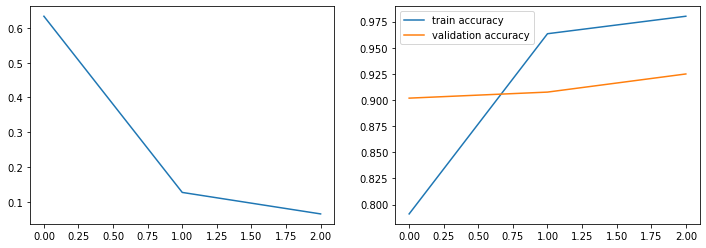

In [41]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

Resultaten zien er alsnog positief uit. Validatie accuraatheid is ook constant. Zoals we eerder al geconcludeerd hadden heeft het neuraal netwerk niet veel last van overfitting. Door het combineren van

- Cross validation
- Dropout
- Test dataset

Lijkt de kans op overfitting verminderd te zijn. Dit model kan geexporteerd worden om als Uiteindelijke model te gebruiken.

# Extra work

Voor de assignment is het mogelijk om extra werk te leveren om hogere punten te halen. Hiervoor zijn er een paar opdrachten opgepakt.

## BatchNormalization

BatchNormalization is een techniek dat gebruikt wordt om het process van het trainen van een netwerk te verbeteren en te versnellen. Het versnellen kan plaatsvinden doordat er minder Epochs nodig zullen zijn om het neurale netwerk te testen. Wanneer er minder epochs nodig zijn, gaat het trainen dus ook sneller.

Wat BatchNormalization eigenlijk doet is de input van een layer te normaliseren.

Dit is voornamelijk handig voor neurale netwerken met meerdere layers. De reden hiervoor is, omdat een neuraal netwerk per layer wordt bijgewerkt. Vanuit de output layer tot en met de input layer worden de gewichten van het neurale netwerk bijgewerkt door de loss functie omdat elke laag telkens verandert, is er vaak lagere learning rates nodig om het model te kunnen trainen. BatchNormalization helpt dus om dit probleem aan te pakken

(Bron: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# import BatchNormalization
from keras.layers.normalization import BatchNormalization

inputs = keras.Input(shape=(32,32,1))

#add BatchNomalization
batchnormalizationLayer = BatchNormalization()(inputs)

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(batchnormalizationLayer)

#add model layers
firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)
flattenLayer = Flatten()(secondLayer)
outputs = layers.Dense(10, activation="softmax")(flattenLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 4s 60ms/step - loss: 1.1643 - accuracy: 0.6326 - val_loss: 0.3213 - val_accuracy: 0.9249
Epoch 2/3
49/49 [==============================] - 3s 56ms/step - loss: 0.1054 - accuracy: 0.9669 - val_loss: 0.2226 - val_accuracy: 0.9364
Epoch 3/3
49/49 [==============================] - 3s 55ms/step - loss: 0.0356 - accuracy: 0.9871 - val_loss: 0.2051 - val_accuracy: 0.9422


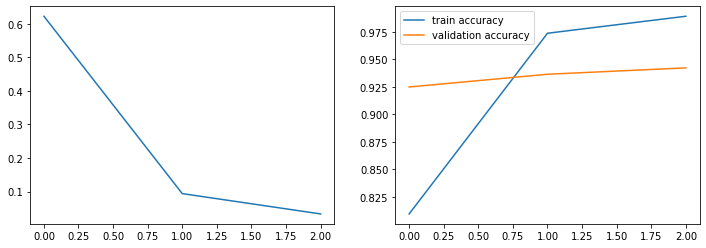

In [45]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

De validatie accuraatheid is een aardig lineare lijn die meegaat met de train accuraatheid. Hoe meer er wordt getraind hoe accurater het wordt. Er zit geen schommeling.

## Other Regularization Technique: Weight Decay

Als extra werk ga ik me verdiepen in een andere techniek. Dit is Weight Decay. Dit is een techniek die gebruik wordt Om overfitting te voorkomen. Keras bevat een API om dit toe te passen.

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.regularizers import l2


inputs = keras.Input(shape=(32,32,1))

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

#add model layers
firstLayer = Conv2D(64, kernel_size=3, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)
flattenLayer = Flatten()(secondLayer)
outputs = layers.Dense(10, activation="softmax")(flattenLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 3s 58ms/step - loss: 1.3461 - accuracy: 0.5659 - val_loss: 0.3131 - val_accuracy: 0.9306
Epoch 2/3
49/49 [==============================] - 3s 55ms/step - loss: 0.1369 - accuracy: 0.9657 - val_loss: 0.3289 - val_accuracy: 0.9133
Epoch 3/3
49/49 [==============================] - 3s 56ms/step - loss: 0.0857 - accuracy: 0.9778 - val_loss: 0.3073 - val_accuracy: 0.9306


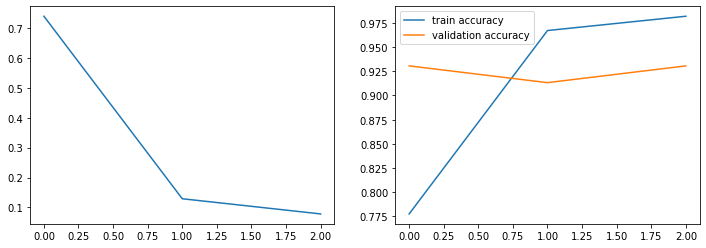

In [48]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12,4))
ax1.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['accuracy'], label='train accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

## Test with Other optimizers

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.regularizers import l2


inputs = keras.Input(shape=(32,32,1))

#add preprocess layers
preprocessed = preprocessing.CenterCrop(height=32, width=32)(inputs)

#add model layers
firstLayer = Conv2D(64, kernel_size=3, activation='relu', input_shape=(32,32,1))(preprocessed)
secondLayer = Conv2D(32, kernel_size=3, activation='relu')(firstLayer)
flattenLayer = Flatten()(secondLayer)
outputs = layers.Dense(10, activation="softmax")(flattenLayer)

#create model
model = None
model = keras.Model(inputs, outputs)

#compile model using accuracy to measure model performance
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#train the model
history = model.fit(X_train, y_train_encoded, validation_split=0.1, epochs=3)

Epoch 1/3
49/49 [==============================] - 3s 57ms/step - loss: 1.9874 - accuracy: 0.3646 - val_loss: 1.2546 - val_accuracy: 0.5723
Epoch 2/3
49/49 [==============================] - 3s 53ms/step - loss: 0.5531 - accuracy: 0.8521 - val_loss: 0.3898 - val_accuracy: 0.8960
Epoch 3/3
49/49 [==============================] - 3s 54ms/step - loss: 0.1659 - accuracy: 0.9526 - val_loss: 0.2936 - val_accuracy: 0.9306


## Export

Exporteer neurale netwerk.